# PreProcessing

In [2]:
import os
import random
import time
import shutil
import zipfile

In [3]:
import cv2
import numpy as np
from PIL import Image

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, random_split

import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder


In [5]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from skimage.feature import hog, local_binary_pattern

In [6]:
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    TrainingArguments,
    Trainer,
    ViltProcessor,
    ViltForQuestionAnswering
)
from sentence_transformers import SentenceTransformer

In [7]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

In [8]:
from google.colab import drive

In [9]:
seed = 782
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
zip_file_path = '/content/drive/My Drive/kaggle_train.zip'
destination_folder = '/content'
os.makedirs(destination_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Files extracted to {destination_folder}")

Files extracted to /content


In [ ]:
input_directory = "/content/kaggle_train/food-101"
output_directory = "/content/drive/My Drive/Sampled_Images"

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
for class_name in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_name)

    if not os.path.isdir(class_path):
        print(f"Skipping non-directory: {class_path}")
        continue

    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print('No images found in this class.')
        continue

    sample_count = max(1, int(len(image_files) * 0.1))
    sampled_images = random.sample(image_files, sample_count)

    class_output_dir = os.path.join(output_directory, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for image_name in sampled_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(class_output_dir, image_name)

        img = cv2.imread(src_path)
        if img is None:
            print(f"Warning: Unable to read {src_path}. Skipping.")
            continue

        img_float = img.astype(np.float32) / 255.0

        img_normalized = (img_float * 255).astype(np.uint8)

        cv2.imwrite(dst_path, img_normalized)

    print(f"Processed class '{class_name}': {len(sampled_images)} images.")


Processed class 'hamburger': 70 images.
Processed class 'caesar_salad': 70 images.
Processed class 'tiramisu': 70 images.
Processed class 'shrimp_and_grits': 70 images.
Processed class 'pho': 70 images.
Processed class 'tacos': 70 images.
Processed class 'beef_carpaccio': 70 images.
Processed class 'pork_chop': 70 images.
Processed class 'paella': 70 images.
Processed class 'strawberry_shortcake': 70 images.
Processed class 'donuts': 70 images.
Processed class 'sashimi': 70 images.
Processed class 'cup_cakes': 70 images.
Processed class 'cheesecake': 70 images.
Processed class 'club_sandwich': 70 images.
Processed class 'ramen': 70 images.
Processed class 'carrot_cake': 70 images.
Processed class 'caprese_salad': 70 images.
Processed class 'apple_pie': 70 images.
Processed class 'miso_soup': 70 images.
Processed class 'croque_madame': 70 images.
Processed class 'spaghetti_bolognese': 70 images.
Processed class 'beef_tartare': 70 images.
Processed class 'escargots': 70 images.
Processed

In [ ]:
data_dir = "/content/drive/MyDrive/Sampled_Images"
class_folders = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])
print("Found classes:", class_folders)
label_mapping = {folder: idx for idx, folder in enumerate(class_folders)}
label_mapping

Found classes: ['apple_pie', 'beef_carpaccio', 'beef_tartare', 'caesar_salad', 'caprese_salad', 'carrot_cake', 'cheesecake', 'club_sandwich', 'creme_brulee', 'croque_madame', 'cup_cakes', 'donuts', 'escargots', 'hamburger', 'hot_and_sour_soup', 'hummus', 'miso_soup', 'oysters', 'paella', 'pho', 'pork_chop', 'ramen', 'samosa', 'sashimi', 'shrimp_and_grits', 'spaghetti_bolognese', 'strawberry_shortcake', 'tacos', 'takoyaki', 'tiramisu']


{'apple_pie': 0,
 'beef_carpaccio': 1,
 'beef_tartare': 2,
 'caesar_salad': 3,
 'caprese_salad': 4,
 'carrot_cake': 5,
 'cheesecake': 6,
 'club_sandwich': 7,
 'creme_brulee': 8,
 'croque_madame': 9,
 'cup_cakes': 10,
 'donuts': 11,
 'escargots': 12,
 'hamburger': 13,
 'hot_and_sour_soup': 14,
 'hummus': 15,
 'miso_soup': 16,
 'oysters': 17,
 'paella': 18,
 'pho': 19,
 'pork_chop': 20,
 'ramen': 21,
 'samosa': 22,
 'sashimi': 23,
 'shrimp_and_grits': 24,
 'spaghetti_bolognese': 25,
 'strawberry_shortcake': 26,
 'tacos': 27,
 'takoyaki': 28,
 'tiramisu': 29}

# Non Competitive

## Classical Features

In [ ]:
def classical(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    img_resized = cv2.resize(img, (224, 224))

    img_normalized = img_resized.astype(np.float32) / 255.0

    img_for_sift = img_resized

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img_for_sift, None)
    h, w = img_for_sift.shape[:2]
    quadrant_features = []
    quadrants = [
        (0, w//2, 0, h//2),
        (w//2, w, 0, h//2),
        (0, w//2, h//2, h),
        (w//2, w, h//2, h)
    ]
    if kp is not None and des is not None and len(des) > 0:
        for (x_start, x_end, y_start, y_end) in quadrants:

            descs = [des[i] for i, point in enumerate(kp)
                     if x_start <= point.pt[0] < x_end and y_start <= point.pt[1] < y_end]
            if descs:
                quadrant_features.append(np.mean(descs, axis=0))
            else:
                quadrant_features.append(np.zeros(128))
        sift_feat = np.concatenate(quadrant_features)
    else:
        sift_feat = np.zeros(512)

    gray_norm = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2GRAY)
    hog_feat, hog_image = hog(gray_norm,
                              pixels_per_cell=(56, 56),
                              cells_per_block=(2, 2),
                              orientations=9,
                              visualize=True,
                              feature_vector=True)

    hist_b = cv2.calcHist([img_normalized], [0], None, [32], [0, 1]).flatten()
    hist_g = cv2.calcHist([img_normalized], [1], None, [32], [0, 1]).flatten()
    hist_r = cv2.calcHist([img_normalized], [2], None, [32], [0, 1]).flatten()
    color_hist = np.concatenate([hist_b, hist_g, hist_r])

    gray_for_edges = cv2.cvtColor(img_for_sift, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_for_edges, 100, 200)
    edge_hist = []
    grid_size = 8
    cell_width = edges.shape[1] // grid_size
    cell_height = edges.shape[0] // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            cell = edges[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]

            edge_hist.append(np.sum(cell) / (255.0 * cell.size))
    edge_hist = np.array(edge_hist)

    lbp = local_binary_pattern(gray_norm, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 8 + 3),
                                 range=(0, 8 + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)

    concat_feat = np.concatenate([sift_feat, hog_feat, color_hist, edge_hist, lbp_hist])

    classical = {
        "sift": sift_feat,
        "hog": hog_feat,
        "color_hist": color_hist,
        "edge": edge_hist,
        "lbp": lbp_hist,
        "concat": concat_feat
    }

    return classical

In [ ]:
Vsift = []
Vhog = []
Vcolor_hist = []
Vedge = []
Vlbp = []
Vconcat =  []

true_labels = []


3 min

In [ ]:
s = time.time()
for folder in class_folders:
    folder_path = os.path.join(data_dir, folder)
    print(folder_path)
    image_files = [img for img in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img))]

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        vector = classical(img_path)
        Vsift.append(vector['sift'])
        Vhog.append(vector['hog']),
        Vcolor_hist.append(vector['color_hist'])
        Vedge.append(vector['edge'])
        Vlbp.append(vector['lbp'])
        Vconcat.append(vector['concat'])

        true_labels.append(label_mapping[folder])

Vsift = np.array(Vsift)
Vhog = np.array(Vhog)
Vcolor_hist = np.array(Vcolor_hist)
Vedge = np.array(Vedge)
Vlbp = np.array(Vlbp)
Vconcat = np.array(Vconcat)

print(Vsift.shape, Vhog.shape, Vcolor_hist.shape, Vedge.shape, Vlbp.shape, Vconcat.shape)
true_labels = np.array(true_labels)
n_clusters = len(class_folders)
print("Clustering into", n_clusters, "clusters.")
print(time.time()-s)

/content/drive/MyDrive/Sampled_Images/apple_pie


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


/content/drive/MyDrive/Sampled_Images/beef_carpaccio
/content/drive/MyDrive/Sampled_Images/beef_tartare
/content/drive/MyDrive/Sampled_Images/caesar_salad
/content/drive/MyDrive/Sampled_Images/caprese_salad
/content/drive/MyDrive/Sampled_Images/carrot_cake
/content/drive/MyDrive/Sampled_Images/cheesecake
/content/drive/MyDrive/Sampled_Images/club_sandwich
/content/drive/MyDrive/Sampled_Images/creme_brulee
/content/drive/MyDrive/Sampled_Images/croque_madame
/content/drive/MyDrive/Sampled_Images/cup_cakes
/content/drive/MyDrive/Sampled_Images/donuts
/content/drive/MyDrive/Sampled_Images/escargots
/content/drive/MyDrive/Sampled_Images/hamburger
/content/drive/MyDrive/Sampled_Images/hot_and_sour_soup
/content/drive/MyDrive/Sampled_Images/hummus
/content/drive/MyDrive/Sampled_Images/miso_soup
/content/drive/MyDrive/Sampled_Images/oysters
/content/drive/MyDrive/Sampled_Images/paella
/content/drive/MyDrive/Sampled_Images/pho
/content/drive/MyDrive/Sampled_Images/pork_chop
/content/drive/MyDri

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Sampled_Images/arrays_data.npz',
                    Vsift=Vsift,
                    Vhog=Vhog,
                    Vcolor_hist=Vcolor_hist,
                    Vedge=Vedge,
                    Vlbp=Vlbp,
                    Vconcat=Vconcat,
                    true_labels=true_labels)

In [ ]:
data = np.load('/content/drive/MyDrive/Sampled_Images/arrays_data.npz')

Vsift = data['Vsift']
Vhog = data['Vhog']
Vcolor_hist = data['Vcolor_hist']
Vedge = data['Vedge']
Vlbp = data['Vlbp']
Vconcat = data['Vconcat']
true_labels = data['true_labels']

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_sift = kmeans.fit_predict(Vsift)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_hog = kmeans.fit_predict(Vhog)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_ch = kmeans.fit_predict(Vcolor_hist)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_edge = kmeans.fit_predict(Vedge)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_lbp = kmeans.fit_predict(Vlbp)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_concat = kmeans.fit_predict(Vconcat)


ari_score_sift = adjusted_rand_score(true_labels, predicted_labels_sift)
print("Adjusted Rand Index (ARI): sift", ari_score_sift)
ari_score_hog = adjusted_rand_score(true_labels, predicted_labels_hog)
print("Adjusted Rand Index (ARI): hog", ari_score_hog)
ari_score_ch = adjusted_rand_score(true_labels, predicted_labels_ch)
print("Adjusted Rand Index (ARI): color_hist", ari_score_ch)
ari_score_edge = adjusted_rand_score(true_labels, predicted_labels_edge)
print("Adjusted Rand Index (ARI): edge", ari_score_edge)
ari_score_lbp = adjusted_rand_score(true_labels, predicted_labels_lbp)
print("Adjusted Rand Index (ARI): lbp", ari_score_lbp)
ari_score_concat = adjusted_rand_score(true_labels, predicted_labels_concat)
print("Adjusted Rand Index (ARI): concat", ari_score_concat)


Adjusted Rand Index (ARI): sift 0.021007597884661843
Adjusted Rand Index (ARI): hog 0.014479009146400476
Adjusted Rand Index (ARI): color_hist 0.007626780783818111
Adjusted Rand Index (ARI): edge 0.019777725427356875
Adjusted Rand Index (ARI): lbp 0.0060186445006258
Adjusted Rand Index (ARI): concat 0.0076868285223702796


In [ ]:
eps_value = 0.5
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_sift = dbscan.fit_predict(Vsift)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_hog = dbscan.fit_predict(Vhog)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_ch = dbscan.fit_predict(Vcolor_hist)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_edge = dbscan.fit_predict(Vedge)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_lbp = dbscan.fit_predict(Vlbp)

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_concat = dbscan.fit_predict(Vconcat)

ari_score_sift = adjusted_rand_score(true_labels, predicted_labels_sift)
print("Adjusted Rand Index (ARI): sift", ari_score_sift)

ari_score_hog = adjusted_rand_score(true_labels, predicted_labels_hog)
print("Adjusted Rand Index (ARI): hog", ari_score_hog)

ari_score_ch = adjusted_rand_score(true_labels, predicted_labels_ch)
print("Adjusted Rand Index (ARI): color_hist", ari_score_ch)

ari_score_edge = adjusted_rand_score(true_labels, predicted_labels_edge)
print("Adjusted Rand Index (ARI): edge", ari_score_edge)

ari_score_lbp = adjusted_rand_score(true_labels, predicted_labels_lbp)
print("Adjusted Rand Index (ARI): lbp", ari_score_lbp)

ari_score_concat = adjusted_rand_score(true_labels, predicted_labels_concat)
print("Adjusted Rand Index (ARI): concat", ari_score_concat)

Adjusted Rand Index (ARI): sift 0.0
Adjusted Rand Index (ARI): hog 0.0
Adjusted Rand Index (ARI): color_hist 0.0
Adjusted Rand Index (ARI): edge 0.006047991854881009
Adjusted Rand Index (ARI): lbp 0.0
Adjusted Rand Index (ARI): concat 0.0


## Deep Features (ResNet)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def deepfeatures_gpu(image_path):

    model = models.resnet50(pretrained=True)
    model.fc = torch.nn.Identity()
    model = model.to(device)
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        raise ValueError(f"Could not load image: {image_path}. Error: {e}")

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img_tensor)

    deep_feat = features.squeeze(0).cpu().numpy()
    return deep_feat


In [ ]:
deepfeatures_gpu("/content/drive/My Drive/Sampled_Images/apple_pie/1112838.jpg")

array([0.00645709, 0.15769617, 0.06029674, ..., 0.47723392, 0.02091707,
       0.05331977], dtype=float32)

15 mins

In [ ]:
all_image_paths = []
all_labels = []

for class_name in os.listdir(output_directory):
    class_dir = os.path.join(output_directory, class_name)

    if not os.path.isdir(class_dir):
        print(f'{class_dir} is not a directory or does not exist.')
        continue

    image_files = [f for f in os.listdir(class_dir)
                   if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        all_image_paths.append(os.path.join(class_dir, img_file))
        all_labels.append(class_name)

with ThreadPoolExecutor(max_workers=64) as executor:
    Vdeep = list(executor.map(deepfeatures_gpu, all_image_paths))

Vdeep = np.array(Vdeep)
true_labels = np.array(all_labels)

np.save("/content/drive/My Drive/Sampled_Images/deep_features.npy", Vdeep)
np.save("/content/drive/My Drive/Sampled_Images/true_labels.npy", true_labels)


/content/drive/My Drive/Sampled_Images/arrays_data.npz is not a directory or does not exist.
/content/drive/My Drive/Sampled_Images/deep_features.npy is not a directory or does not exist.
/content/drive/My Drive/Sampled_Images/true_labels.npy is not a directory or does not exist.


In [ ]:
kmeans = KMeans(n_clusters=30, random_state=782)
predicted_labels_deep = kmeans.fit_predict(Vdeep)

ari_score_deep = adjusted_rand_score(true_labels, predicted_labels_deep)
print("Adjusted Rand Index (ARI): deep", ari_score_deep)


Adjusted Rand Index (ARI): deep 0.22854243772810828


In [ ]:
eps_value = 0.5
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_deep = dbscan.fit_predict(Vdeep)

ari_score_deep = adjusted_rand_score(true_labels, predicted_labels_deep)
print("Adjusted Rand Index (ARI): deep", ari_score_deep)


Adjusted Rand Index (ARI): deep 0.0


## BLIP BaseLine

In [ ]:
! pip install transformers sentence-transformers scikit-learn pillow torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 377.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 740.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 754.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nv

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
captions = []
gt_labels = []

In [ ]:
base_dir ="/content/drive/My Drive/Sampled_Images"

10 min

In [ ]:
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_path = os.path.join(class_path, file)
                try:
                    image = Image.open(image_path).convert("RGB")
                    inputs = processor(image, return_tensors="pt").to(device)
                    output_ids = model.generate(**inputs)
                    caption = processor.decode(output_ids[0], skip_special_tokens=True)

                    captions.append(caption)
                    gt_labels.append(class_folder)

                    print(f"Processed {image_path}: {caption}")
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")


Processed /content/drive/My Drive/Sampled_Images/hamburger/245244.jpg: a table with two plates of food and drinks
Processed /content/drive/My Drive/Sampled_Images/hamburger/1584018.jpg: a plate with a hamburger and fries on it
Processed /content/drive/My Drive/Sampled_Images/hamburger/3549095.jpg: a plate with a sandwich and some vegetables
Processed /content/drive/My Drive/Sampled_Images/hamburger/2212320.jpg: a plate of food with fries and a burger
Processed /content/drive/My Drive/Sampled_Images/hamburger/129939.jpg: a tray of food on a table
Processed /content/drive/My Drive/Sampled_Images/hamburger/878103.jpg: a plate of food with a burger and fries
Processed /content/drive/My Drive/Sampled_Images/hamburger/3140245.jpg: a plate with a sandwich and a salad
Processed /content/drive/My Drive/Sampled_Images/hamburger/3575210.jpg: a green plate topped with a hamburger with a cherry on top
Processed /content/drive/My Drive/Sampled_Images/hamburger/419342.jpg: a burger with bacon and che

In [ ]:
embeddings = sbert_model.encode(captions, show_progress_bar=True)


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
np.save('/content/drive/My Drive/Sampled_Images/embeddings.npy', embeddings)
np.save('/content/drive/My Drive/Sampled_Images/predicted_labels.npy', predicted_labels)
np.save('/content/drive/My Drive/Sampled_Images/gt_labels.npy', np.array(gt_labels))

In [ ]:
n_clusters = len(set(gt_labels))
print(n_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels = kmeans.fit_predict(embeddings)

ari = adjusted_rand_score(gt_labels, predicted_labels)
print(f"\nAdjusted Rand Index (ARI): {ari}")

30

Adjusted Rand Index (ARI): 0.21148239856154566


In [ ]:
eps_value = 0.5
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels = dbscan.fit_predict(embeddings)

ari = adjusted_rand_score(gt_labels, predicted_labels)
print(f"\nAdjusted Rand Index (ARI): {ari}")


Adjusted Rand Index (ARI): 0.014010664784095543


# Competitive

## Deep Features (EffNet)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def deepfeatures_gpu2(image_path):

    model = models.efficientnet_b0(pretrained=True)
    model.fc = torch.nn.Identity()
    model = model.to(device)
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        raise ValueError(f"Could not load image: {image_path}. Error: {e}")

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img_tensor)

    deep_feat = features.squeeze(0).cpu().numpy()
    return deep_feat


In [ ]:
deepfeatures_gpu2("/content/drive/My Drive/Sampled_Images/apple_pie/1112838.jpg")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


array([-9.65883195e-01, -1.22123742e+00, -1.72175586e-01,  2.32568339e-01,
        4.24819440e-02,  1.36090660e+00, -2.17887759e-01, -4.98263717e-01,
       -1.35766757e+00, -1.32343292e-01, -8.12913895e-01, -6.59889936e-01,
       -7.31422484e-01,  1.58102036e-01, -1.63704440e-01, -1.23762965e+00,
       -4.77851450e-01, -4.15843368e-01, -5.43588340e-01, -9.40159500e-01,
        6.48855150e-01,  1.58986941e-01,  3.68270218e-01, -3.32588851e-01,
        1.79038703e-01, -4.97974932e-01,  1.26389337e+00, -2.42548257e-01,
       -5.48085347e-02, -7.96459243e-02, -6.24597669e-01, -2.29367599e-01,
        2.27377683e-01, -1.18027270e+00, -6.55391276e-01, -2.01857400e+00,
       -5.95368326e-01, -1.09726083e+00,  5.83443046e-02, -7.37838984e-01,
       -3.15591216e-01, -1.02336951e-01, -5.52629590e-01, -6.26772821e-01,
        5.86737752e-01, -2.71990836e-01, -4.19565260e-01, -4.26352322e-01,
        4.47687715e-01,  1.96394950e-01, -1.09030676e+00, -9.36096132e-01,
        3.77172083e-01, -

6 min

In [ ]:
all_image_paths = []
all_labels = []

for class_name in os.listdir(output_directory):
    class_dir = os.path.join(output_directory, class_name)

    if not os.path.isdir(class_dir):
        print(f'{class_dir} is not a directory or does not exist.')
        continue

    image_files = [f for f in os.listdir(class_dir)
                   if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        all_image_paths.append(os.path.join(class_dir, img_file))
        all_labels.append(class_name)

with ThreadPoolExecutor(max_workers=64) as executor:
    Vdeep = list(executor.map(deepfeatures_gpu2, all_image_paths))

Vdeep2 = np.array(Vdeep)
true_labels2 = np.array(all_labels)

np.save("/content/drive/My Drive/Sampled_Images/deep_features2.npy", Vdeep2)
np.save("/content/drive/My Drive/Sampled_Images/true_labels2.npy", true_labels2)


In [ ]:
kmeans = KMeans(n_clusters=30, random_state=782)
predicted_labels_deep2 = kmeans.fit_predict(Vdeep2)

ari_score_deep = adjusted_rand_score(true_labels2, predicted_labels_deep2)
print("Adjusted Rand Index (ARI): deep2", ari_score_deep)


Adjusted Rand Index (ARI): deep2 0.2791003753160174


In [ ]:
eps_value = 0.5
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_deep2 = dbscan.fit_predict(Vdeep2)

ari_score_deep = adjusted_rand_score(true_labels2, predicted_labels_deep2)
print("Adjusted Rand Index (ARI): deep2", ari_score_deep)


Adjusted Rand Index (ARI): deep2 0.0


## VLIT VQA

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa").to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
captions = []
gt_labels = []

In [ ]:
base_dir = "/content/drive/My Drive/Sampled_Images"

In [ ]:
classes = ''
for class_name in os.listdir(base_dir):
    classes = classes + class_name.replace('_', ' ') + ', '

In [ ]:
classes

'hamburger, caesar salad, tiramisu, shrimp and grits, pho, tacos, beef carpaccio, pork chop, paella, strawberry shortcake, donuts, sashimi, cup cakes, cheesecake, club sandwich, ramen, carrot cake, caprese salad, apple pie, miso soup, croque madame, spaghetti bolognese, beef tartare, escargots, hummus, hot and sour soup, creme brulee, samosa, oysters, takoyaki, TEXT, DEEP, CLASSICAL, deep features2.npy, true labels2.npy, '

40 sequence len limit

In [ ]:
question = 'Which dish is in this image ?'

25 min

In [ ]:
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_path = os.path.join(class_path, file)
                try:
                    image = Image.open(image_path).convert("RGB")
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    # question = "Which dish is in this image ?"
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    inputs = processor(image, question, return_tensors="pt").to(device)

                    outputs = model(**inputs)
                    answer = processor.tokenizer.decode(outputs.logits.argmax(-1)[0])

                    captions.append(answer)
                    gt_labels.append(class_folder)

                    print(f"Processed {image_path}: {answer}")
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")


Processed /content/drive/My Drive/Sampled_Images/hamburger/245244.jpg: [unused103]
Processed /content/drive/My Drive/Sampled_Images/hamburger/1584018.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/3549095.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/2212320.jpg: [unused706]
Processed /content/drive/My Drive/Sampled_Images/hamburger/129939.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/878103.jpg: [unused706]
Processed /content/drive/My Drive/Sampled_Images/hamburger/3140245.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/3575210.jpg: গ
Processed /content/drive/My Drive/Sampled_Images/hamburger/419342.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/3433981.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/992590.jpg: [unused345]
Processed /content/drive/My Drive/Sampled_Images/hamburger/2566738.jpg: [unused706]
Process

In [ ]:
embeddings = sbert_model.encode(captions, show_progress_bar=True)

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
n_clusters = len(set(gt_labels))
print("Number of clusters:", n_clusters)

kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels = kmeans.fit_predict(embeddings)
ari = adjusted_rand_score(gt_labels, predicted_labels)
print(f"\nAdjusted Rand Index (ARI) using KMeans: {ari}")


Number of clusters: 30

Adjusted Rand Index (ARI) using KMeans: 0.17616075336059256


In [ ]:
eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_dbscan = dbscan.fit_predict(embeddings)
ari_dbscan = adjusted_rand_score(gt_labels, predicted_labels_dbscan)
print(f"\nAdjusted Rand Index (ARI) using DBSCAN: {ari_dbscan}")


Adjusted Rand Index (ARI) using DBSCAN: 0.042618671237520944


## FINETUNING

## Finetuned EffNet

In [ ]:

def split_dataset(base_dir, output_base_dir, split_ratio=0.5):
    random.seed(782)
    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)
        images = [f for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        random.shuffle(images)
        split_index = int(len(images) * split_ratio)

        train_images = images[:split_index]
        test_images = images[split_index:]

        train_dir = os.path.join(output_base_dir, 'train', class_name)
        test_dir = os.path.join(output_base_dir, 'test', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        for img in train_images:
            src_path = os.path.join(class_dir, img)
            dst_path = os.path.join(train_dir, img)
            shutil.copy2(src_path, dst_path)

        for img in test_images:
            src_path = os.path.join(class_dir, img)
            dst_path = os.path.join(test_dir, img)
            shutil.copy2(src_path, dst_path)

        print(f"Class '{class_name}': {len(train_images)} train images, {len(test_images)} test images.")

base_dir = "/content/drive/My Drive/Sampled_Images"
output_base_dir = "/content/drive/My Drive/TrainTestImgs"
split_dataset(base_dir, output_base_dir)

Class 'caesar_salad': 35 train images, 35 test images.
Class 'TEXT': 0 train images, 0 test images.
Class 'croque_madame': 35 train images, 35 test images.
Class 'ramen': 35 train images, 35 test images.
Class 'carrot_cake': 35 train images, 35 test images.
Class 'hamburger': 35 train images, 35 test images.
Class 'pho': 35 train images, 35 test images.
Class 'oysters': 35 train images, 35 test images.
Class 'creme_brulee': 35 train images, 35 test images.
Class 'caprese_salad': 35 train images, 35 test images.
Class 'CLASSICAL': 0 train images, 0 test images.
Class 'hummus': 35 train images, 35 test images.
Class 'escargots': 35 train images, 35 test images.
Class 'tacos': 35 train images, 35 test images.
Class 'beef_carpaccio': 35 train images, 35 test images.
Class 'pork_chop': 35 train images, 35 test images.
Class 'apple_pie': 35 train images, 35 test images.
Class 'miso_soup': 35 train images, 35 test images.
Class 'tiramisu': 35 train images, 35 test images.
Class 'takoyaki': 35

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
output_base_dir = "/content/drive/My Drive/TrainTestImgs"

In [ ]:
len(os.listdir('/content/drive/My Drive/TrainTestImgs/test'))

30

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = os.path.join(output_base_dir, 'train')
test_dir = os.path.join(output_base_dir, 'test')
print(test_dir)
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/content/drive/My Drive/TrainTestImgs/test


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:

model = models.efficientnet_b0(pretrained=True)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 30)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 50.5MB/s]


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f} - Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5 - Training Loss: 3.3541 - Test Accuracy: 0.1810
Epoch 2/5 - Training Loss: 3.0026 - Test Accuracy: 0.4029
Epoch 3/5 - Training Loss: 2.5975 - Test Accuracy: 0.5219
Epoch 4/5 - Training Loss: 2.1154 - Test Accuracy: 0.5829
Epoch 5/5 - Training Loss: 1.6719 - Test Accuracy: 0.6171


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = correct / total
    print(f"Epoch {epoch+1+5}/{num_epochs} - Training Loss: {epoch_loss:.4f} - Test Accuracy: {acc:.4f}")

Epoch 6/5 - Training Loss: 1.2699 - Test Accuracy: 0.6543
Epoch 7/5 - Training Loss: 0.9469 - Test Accuracy: 0.6752
Epoch 8/5 - Training Loss: 0.6847 - Test Accuracy: 0.6886
Epoch 9/5 - Training Loss: 0.5108 - Test Accuracy: 0.6962
Epoch 10/5 - Training Loss: 0.3926 - Test Accuracy: 0.6952


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = correct / total
    print(f"Epoch {epoch+1+10}/{num_epochs} - Training Loss: {epoch_loss:.4f} - Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/5 - Training Loss: 0.2838 - Test Accuracy: 0.7010
Epoch 12/5 - Training Loss: 0.2189 - Test Accuracy: 0.7057
Epoch 13/5 - Training Loss: 0.1839 - Test Accuracy: 0.7000
Epoch 14/5 - Training Loss: 0.1426 - Test Accuracy: 0.7162
Epoch 15/5 - Training Loss: 0.1031 - Test Accuracy: 0.7124


6 mins to finetune

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/FINETUNEDEFFNET.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
def deepfeatures_gpu_finetuned(image_path, model, device):
    model.eval()
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(image_path).convert('RGB')
    except Exception as e:
        raise ValueError(f"Could not load image: {image_path}. Error: {e}")

    img_tensor = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.features(img_tensor)
        pooled = model.avgpool(features)
        penultimate = pooled.flatten(1)

    deep_feat = penultimate.squeeze(0).cpu().numpy()
    if deep_feat.shape != (1280,):
        print(deep_feat.shape)
    return deep_feat

In [ ]:
test_img_dir = "/content/drive/My Drive/TrainTestImgs/test"

In [ ]:
all_image_paths = []
all_labels = []

for class_name in os.listdir(test_img_dir):
    class_dir = os.path.join(test_img_dir, class_name)
    if not os.path.isdir(class_dir):
        print(f'{class_dir} is not a directory or does not exist.')
        continue

    image_files = [f for f in os.listdir(class_dir)
                   if os.path.isfile(os.path.join(class_dir, f)) and
                   f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in image_files:
        all_image_paths.append(os.path.join(class_dir, img_file))
        all_labels.append(class_name)


In [ ]:
from functools import partial

In [ ]:
model = models.efficientnet_b0(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(in_features, 30)
model.load_state_dict(torch.load("/content/drive/My Drive/FINETUNEDEFFNET.pth", map_location=device))
model = model.to(device)

1 min

In [ ]:
with ThreadPoolExecutor(max_workers=64) as executor:
    features_list = list(executor.map(lambda path: deepfeatures_gpu_finetuned(path, model, device), all_image_paths))

In [ ]:
features_array = np.array(features_list)
labels_array = np.array(all_labels)

np.save("/content/drive/My Drive/deep_features2_finetuned.npy", features_array)
np.save("/content/drive/My Drive/true_labels2_finetuned.npy", labels_array)



In [ ]:
features_array.shape

(1050, 1280)

In [ ]:
Vdeep_finetuned = features_array
true_labels_finetuned = labels_array

In [ ]:
kmeans = KMeans(n_clusters=30, random_state=782)
predicted_labels_deep_finetuned = kmeans.fit_predict(Vdeep_finetuned)
ari_score_deep = adjusted_rand_score(true_labels_finetuned, predicted_labels_deep_finetuned)
print("Adjusted Rand Index (ARI) with KMeans: deep_finetuned", ari_score_deep)

eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_deep_finetuned = dbscan.fit_predict(Vdeep_finetuned)
ari_score_deep = adjusted_rand_score(true_labels_finetuned, predicted_labels_deep_finetuned)
print("Adjusted Rand Index (ARI) with DBSCAN: deep_finetuned", ari_score_deep)


Adjusted Rand Index (ARI) with KMeans: deep_finetuned 0.4540482741410825
Adjusted Rand Index (ARI) with DBSCAN: deep_finetuned 0.0


## Finetuned BLIP

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform
        self.data = []

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                caption = "This is an image of " + class_name.replace('_', ' ')
                for file_name in os.listdir(class_path):
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        file_path = os.path.join(class_path, file_name)
                        self.data.append({
                            "image_path": file_path,
                            "caption": caption,
                            "gt_label": class_name,
                        })

        self.data.sort(key=lambda x: x["gt_label"])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        caption = item["caption"]
        inputs = self.processor(images=image, text=caption,
                                return_tensors="pt",
                                padding="max_length",
                                truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        labels = inputs["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        inputs["labels"] = labels

        inputs["gt_label"] = item["gt_label"]
        inputs["image_path"] = item["image_path"]
        return inputs

In [ ]:
dataset_root = "/content/drive/My Drive/Sampled_Images"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
master_dataset = ImageCaptionDataset(root_dir=dataset_root, processor=processor)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
from collections import defaultdict
class_indices = defaultdict(list)
for idx, sample in enumerate(master_dataset.data):
    class_indices[sample["gt_label"]].append(idx)

train_indices = []
test_indices = []
for indices in class_indices.values():
    random.shuffle(indices)
    split_point = len(indices) // 2
    train_indices.extend(indices[:split_point])
    test_indices.extend(indices[split_point:])

In [ ]:
from torch.utils.data import Subset
train_dataset = Subset(master_dataset, train_indices)
test_dataset = Subset(master_dataset, test_indices)

In [ ]:
len(train_dataset), len(test_dataset)

(1050, 1050)

In [ ]:
def collate_fn(batch):
    collated = {}
    for key in batch[0].keys():
        if key in ["gt_label", "image_path"]:
            collated[key] = [item[key] for item in batch]
        else:
            collated[key] = torch.stack([item[key] for item in batch])
    return collated

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/Sampled_Images/blip-finetuned_balanced",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    evaluation_strategy="no",
    save_steps=500,
    logging_steps=100,
    learning_rate=5e-5,
    fp16=True,
    gradient_accumulation_steps=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

20 min

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hj1912003 (hj1912003-iit-delhi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=655, training_loss=0.06878795088588736, metrics={'train_runtime': 1068.8448, 'train_samples_per_second': 4.912, 'train_steps_per_second': 0.613, 'total_flos': 3.095297770005725e+18, 'train_loss': 0.06878795088588736, 'epoch': 4.965779467680608})

In [ ]:
captions = []
gt_labels = []

for sample in test_dataset:
    image_path = sample["image_path"]
    gt_label = sample["gt_label"]
    try:
        image = Image.open(image_path).convert("RGB")

        inputs = processor(image, return_tensors="pt", padding="max_length", truncation=True).to(device)

        output_ids = model.generate(**inputs)
        caption = processor.decode(output_ids[0], skip_special_tokens=True)
        captions.append(caption)
        gt_labels.append(gt_label)
        print(f"Processed {image_path}: {caption}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

Processed /content/drive/My Drive/Sampled_Images/apple_pie/2298862.jpg: this is an image of takoyaki
Processed /content/drive/My Drive/Sampled_Images/apple_pie/3539782.jpg: this is an image of apple pie
Processed /content/drive/My Drive/Sampled_Images/apple_pie/2434963.jpg: this is an image of apple pie
Processed /content/drive/My Drive/Sampled_Images/apple_pie/3814952.jpg: this is an image of cheesecake
Processed /content/drive/My Drive/Sampled_Images/apple_pie/793078.jpg: this is an image of apple pie
Processed /content/drive/My Drive/Sampled_Images/apple_pie/1710288.jpg: this is an image of takoyaki
Processed /content/drive/My Drive/Sampled_Images/apple_pie/1272778.jpg: this is an image of apple pie
Processed /content/drive/My Drive/Sampled_Images/apple_pie/1830215.jpg: this is an image of cheesecake
Processed /content/drive/My Drive/Sampled_Images/apple_pie/2306493.jpg: this is an image of carrot cake
Processed /content/drive/My Drive/Sampled_Images/apple_pie/2969119.jpg: this is a

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = sbert_model.encode(captions, show_progress_bar=True)

np.save('/content/drive/My Drive/Sampled_Images/embeddings_finetunedblip.npy', embeddings)
np.save('/content/drive/My Drive/Sampled_Images/gt_labels_finetunedblip.npy', np.array(gt_labels))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
n_clusters = len(set(gt_labels))
print(n_clusters)

30


In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_kmeans = kmeans.fit_predict(embeddings)
ari_kmeans = adjusted_rand_score(gt_labels, predicted_labels_kmeans)
print(f"ari kmeans finetuned: {ari_kmeans}")

ri kmeans finetuned: 0.7726063197713863


In [ ]:
eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_dbscan = dbscan.fit_predict(embeddings)
ari_dbscan = adjusted_rand_score(gt_labels, predicted_labels_dbscan)
print(f"ari dbscan finetuned: {ari_dbscan}")

ari dbscan finetuned: 0.7740731753474627


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Visualization

In [11]:
embeddings = np.load('/content/drive/My Drive/Sampled_Images/embeddings_finetunedblip.npy')
gt_labels = np.load('/content/drive/My Drive/Sampled_Images/gt_labels_finetunedblip.npy')

In [16]:
gt_labels

array(['apple_pie', 'apple_pie', 'apple_pie', ..., 'tiramisu', 'tiramisu',
       'tiramisu'], dtype='<U20')

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=782)
embeddingstSNE = tsne.fit_transform(embeddings)

In [13]:
embeddingstSNE.shape

(1050, 2)

In [17]:
le = LabelEncoder()
gt_labels = le.fit_transform(gt_labels)

<ipython-input-19-8d12bb0060b8>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


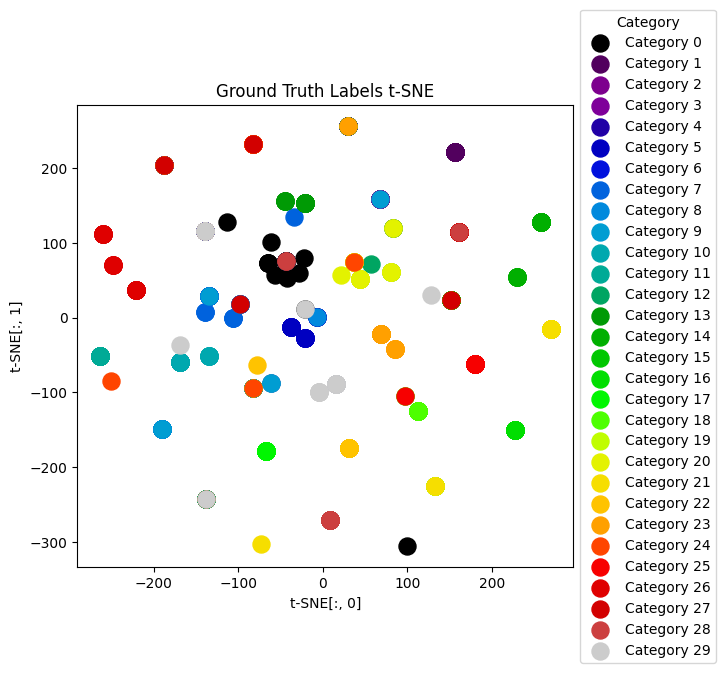

In [19]:
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6))

unique_labels = np.unique(gt_labels)
for label in unique_labels:
    idx = gt_labels == label
    ax.scatter(embeddingstSNE[idx, 0], embeddingstSNE[idx, 1],
               color=cmap(label),
               label=f'Category {label}',
               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('Ground Truth Labels t-SNE')
plt.show()

In [21]:
kmeans = KMeans(n_clusters=30, random_state=782)
predicted_labels_kmeans = kmeans.fit_predict(embeddings)
ari_kmeans = adjusted_rand_score(gt_labels, predicted_labels_kmeans)
print(f"ari kmeans finetuned: {ari_kmeans}")

ari kmeans finetuned: 0.7726063197713863


In [22]:
eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_dbscan = dbscan.fit_predict(embeddings)
ari_dbscan = adjusted_rand_score(gt_labels, predicted_labels_dbscan)
print(f"ari dbscan finetuned: {ari_dbscan}")

ari dbscan finetuned: 0.7740731753474627


<ipython-input-23-c3533d057b45>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


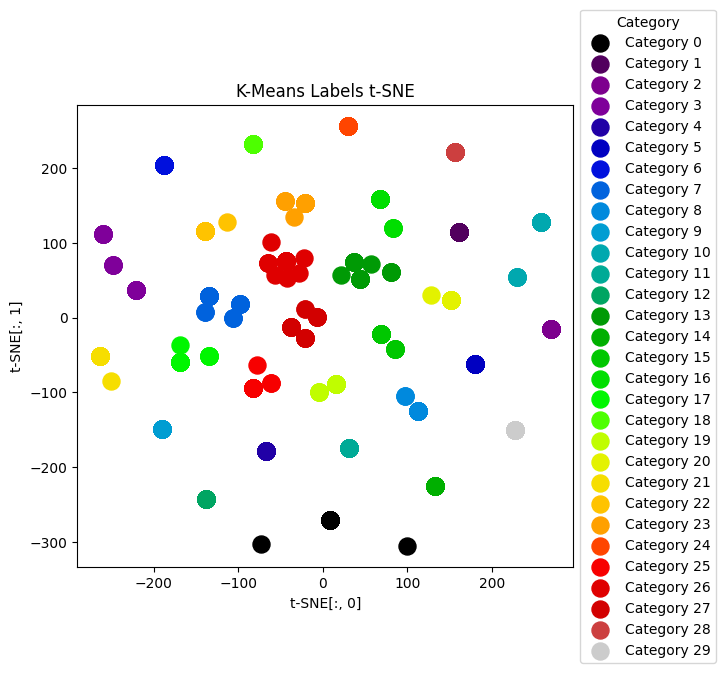

In [23]:
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6))

unique_labels = np.unique(predicted_labels_kmeans)
for label in unique_labels:
    idx = predicted_labels_kmeans == label
    ax.scatter(embeddingstSNE[idx, 0], embeddingstSNE[idx, 1],
               color=cmap(label),
               label=f'Category {label}',
               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('K-Means Labels t-SNE')
plt.show()

<ipython-input-25-8ff2db96c3af>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


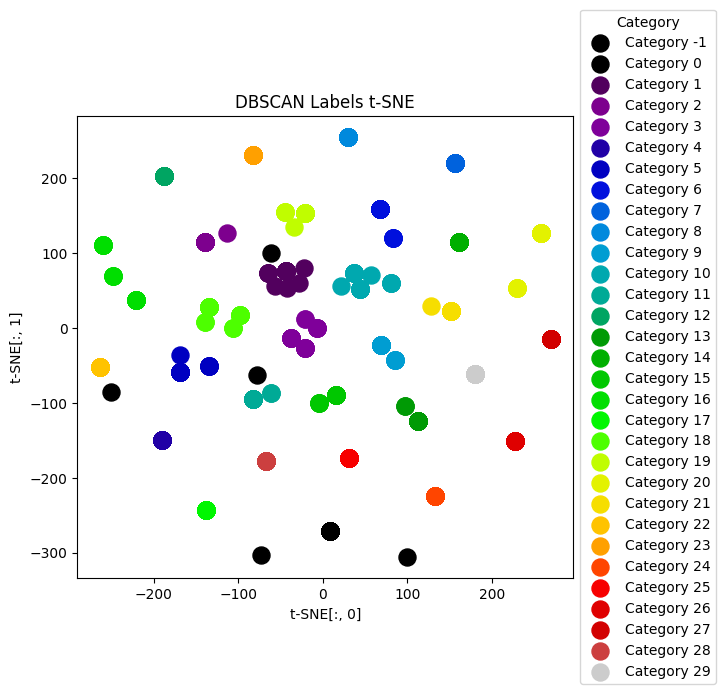

In [25]:
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6))

unique_labels = np.unique(predicted_labels_dbscan)
for label in unique_labels:
    idx = predicted_labels_dbscan == label
    ax.scatter(embeddingstSNE[idx, 0], embeddingstSNE[idx, 1],
               color=cmap(label),
               label=f'Category {label}',
               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('DBSCAN Labels t-SNE')
plt.show()

## Compressing FT BLIP Embeddings

In [ ]:
seed = 782
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
embeddings = np.load('/content/drive/My Drive/Sampled_Images/embeddings_finetunedblip.npy')
gt_labels = np.load('/content/drive/My Drive/Sampled_Images/gt_labels_finetunedblip.npy')

In [ ]:
le = LabelEncoder()
gt_labels_encoded = le.fit_transform(gt_labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, gt_labels_encoded, test_size=0.2, random_state=782
)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

In [ ]:
X_train.shape

torch.Size([840, 768])

In [ ]:
class CompressNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=30):
        super(CompressNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        embeddings = x
        x = self.fc2(x)
        return x, embeddings

In [ ]:
model = CompressNet(768, 128, 30)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
device

device(type='cuda')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/20, Train Loss: 3.3318, Val Loss: 3.2498
Epoch 2/20, Train Loss: 3.0933, Val Loss: 2.9670
Epoch 3/20, Train Loss: 2.6976, Val Loss: 2.5519
Epoch 4/20, Train Loss: 2.1843, Val Loss: 2.0679
Epoch 5/20, Train Loss: 1.6707, Val Loss: 1.6441
Epoch 6/20, Train Loss: 1.2613, Val Loss: 1.3267
Epoch 7/20, Train Loss: 0.9982, Val Loss: 1.1348
Epoch 8/20, Train Loss: 0.8372, Val Loss: 1.0257
Epoch 9/20, Train Loss: 0.7423, Val Loss: 0.9564
Epoch 10/20, Train Loss: 0.6827, Val Loss: 0.9244
Epoch 11/20, Train Loss: 0.6426, Val Loss: 0.9071
Epoch 12/20, Train Loss: 0.6154, Val Loss: 0.8950
Epoch 13/20, Train Loss: 0.5912, Val Loss: 0.8743
Epoch 14/20, Train Loss: 0.5762, Val Loss: 0.8719
Epoch 15/20, Train Loss: 0.5623, Val Loss: 0.8732
Epoch 16/20, Train Loss: 0.5530, Val Loss: 0.8718
Epoch 17/20, Train Loss: 0.5421, Val Loss: 0.8750
Epoch 18/20, Train Loss: 0.5335, Val Loss: 0.8685
Epoch 19/20, Train Loss: 0.5278, Val Loss: 0.8747
Epoch 20/20, Train Loss: 0.5239, Val Loss: 0.8814


In [ ]:
X_all = torch.tensor(embeddings, dtype=torch.float32)
embeddings_reduced = []
model.eval()
with torch.no_grad():
    for i in range(0, len(X_all), batch_size):
        batch_X = X_all[i:i + batch_size].to(device)
        _, batch_embeddings = model(batch_X)
        embeddings_reduced.append(batch_embeddings.cpu().numpy())
embeddings_reduced = np.concatenate(embeddings_reduced, axis=0)

In [ ]:
np.save('/content/drive/My Drive/Sampled_Images/finetunedBLIPreduced.npy', embeddings_reduced)

In [ ]:
n_clusters = len(set(gt_labels))
print(n_clusters)

30


In [ ]:
embeddings_reduced.shape

(1050, 128)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_kmeans = kmeans.fit_predict(embeddings_reduced)
ari_kmeans = adjusted_rand_score(gt_labels, predicted_labels_kmeans)
print(f"ari kmeans finetuned_reduced: {ari_kmeans}")

ari kmeans finetuned_reduced: 0.7760355325714324


In [ ]:
eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_dbscan = dbscan.fit_predict(embeddings_reduced)
ari_dbscan = adjusted_rand_score(gt_labels, predicted_labels_dbscan)
print(f"ari dbscan finetuned_reduced: {ari_dbscan}")

ari dbscan finetuned_reduced: 0.7740731753474627


# Final Training and Testing

In [ ]:
zip_file_path = '/content/drive/My Drive/kaggle_train.zip'
destination_folder = '/content'
os.makedirs(destination_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Files extracted to {destination_folder}")

Files extracted to /content


In [ ]:
input_directory = "/content/kaggle_train/food-101"
output_directory = "/content/drive/My Drive/finaltrain"

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
for class_name in os.listdir(input_directory):
    class_path = os.path.join(input_directory, class_name)

    if not os.path.isdir(class_path):
        print(f"Skipping non-directory: {class_path}")
        continue

    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print('No images found in this class.')
        continue

    sample_count = max(1, int(len(image_files) * 0.2))
    sampled_images = random.sample(image_files, sample_count)

    class_output_dir = os.path.join(output_directory, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for image_name in sampled_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(class_output_dir, image_name)

        img = cv2.imread(src_path)
        if img is None:
            print(f"Warning: Unable to read {src_path}. Skipping.")
            continue

        img_float = img.astype(np.float32) / 255.0

        img_normalized = (img_float * 255).astype(np.uint8)

        cv2.imwrite(dst_path, img_normalized)

    print(f"Processed class '{class_name}': {len(sampled_images)} images.")


Processed class 'donuts': 140 images.
Processed class 'sashimi': 140 images.
Processed class 'pho': 140 images.
Processed class 'samosa': 140 images.
Processed class 'miso_soup': 140 images.
Processed class 'croque_madame': 140 images.
Processed class 'escargots': 140 images.
Processed class 'club_sandwich': 140 images.
Processed class 'carrot_cake': 140 images.
Processed class 'caprese_salad': 140 images.
Processed class 'hot_and_sour_soup': 140 images.
Processed class 'paella': 140 images.
Processed class 'oysters': 140 images.
Processed class 'shrimp_and_grits': 140 images.
Processed class 'takoyaki': 140 images.
Processed class 'apple_pie': 140 images.
Processed class 'caesar_salad': 140 images.
Processed class 'spaghetti_bolognese': 140 images.
Processed class 'hamburger': 140 images.
Processed class 'cup_cakes': 140 images.
Processed class 'strawberry_shortcake': 140 images.
Processed class 'cheesecake': 140 images.
Processed class 'tiramisu': 140 images.
Processed class 'pork_ch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform
        self.data = []

        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                caption = "This is an image of " + class_name.replace('_', ' ')
                for file_name in os.listdir(class_path):
                    if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        file_path = os.path.join(class_path, file_name)
                        self.data.append({
                            "image_path": file_path,
                            "caption": caption,
                            "gt_label": class_name,
                        })

        self.data.sort(key=lambda x: x["gt_label"])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        caption = item["caption"]
        inputs = self.processor(images=image, text=caption,
                                return_tensors="pt",
                                padding="max_length",
                                truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        labels = inputs["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        inputs["labels"] = labels

        inputs["gt_label"] = item["gt_label"]
        inputs["image_path"] = item["image_path"]
        return inputs

In [ ]:
dataset_root = "/content/drive/My Drive/finaltrain"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
master_dataset = ImageCaptionDataset(root_dir=dataset_root, processor=processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
from collections import defaultdict
class_indices = defaultdict(list)
for idx, sample in enumerate(master_dataset.data):
    class_indices[sample["gt_label"]].append(idx)

train_indices = []
test_indices = []
for indices in class_indices.values():
    random.shuffle(indices)
    split_point = int(len(indices)*0.8)
    train_indices.extend(indices[:split_point])
    test_indices.extend(indices[split_point:])

In [ ]:
from torch.utils.data import Subset
train_dataset = Subset(master_dataset, train_indices)
test_dataset = Subset(master_dataset, test_indices)

In [ ]:
len(train_dataset), len(test_dataset)

(3360, 840)

In [ ]:
def collate_fn(batch):
    collated = {}
    for key in batch[0].keys():
        if key in ["gt_label", "image_path"]:
            collated[key] = [item[key] for item in batch]
        else:
            collated[key] = torch.stack([item[key] for item in batch])
    return collated

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/Sampled_Images/FINAL_blip-finetuned",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    evaluation_strategy="no",
    save_steps=500,
    logging_steps=100,
    learning_rate=5e-5,
    fp16=True,
    gradient_accumulation_steps=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
)

**40** min

In [ ]:
trainer.train()
final_save_path = "/content/drive/My Drive/FINALFINETUNED2"
trainer.save_model(final_save_path)
print('saved')


saved


In [ ]:
final_save_path = "/content/drive/My Drive/FINALFINETUNED2"
trainer.save_model(final_save_path)

4min

In [ ]:
captions = []
gt_labels = []

for sample in test_dataset:
    image_path = sample["image_path"]
    gt_label = sample["gt_label"]
    try:
        image = Image.open(image_path).convert("RGB")

        inputs = processor(image, return_tensors="pt", padding="max_length", truncation=True).to(device)

        output_ids = model.generate(**inputs)
        caption = processor.decode(output_ids[0], skip_special_tokens=True)
        captions.append(caption)
        gt_labels.append(gt_label)
        print(f"Processed {image_path}: {caption}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

Processed /content/drive/My Drive/finaltrain/apple_pie/2224273.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/3419799.jpg: this is an image of pork chop
Processed /content/drive/My Drive/finaltrain/apple_pie/939246.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/3214268.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/3915887.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/2989031.jpg: this is an image of donuts
Processed /content/drive/My Drive/finaltrain/apple_pie/2977851.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/839808.jpg: this is an image of apple pie
Processed /content/drive/My Drive/finaltrain/apple_pie/547961.jpg: this is an image of strawberry shortcake
Processed /content/drive/My Drive/finaltrain/apple_pie/2928660.jpg: this is an image of apple pie
Processed /cont

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = sbert_model.encode(captions, show_progress_bar=True)

np.save('/content/drive/My Drive/Sampled_Images/embeddings_FINALfinetunedblip.npy', embeddings)
np.save('/content/drive/My Drive/Sampled_Images/gt_labels_FINALfinetunedblip.npy', np.array(gt_labels))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
n_clusters = len(set(gt_labels))
print(n_clusters)

30


In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=782)
predicted_labels_kmeans = kmeans.fit_predict(embeddings)
ari_kmeans = adjusted_rand_score(gt_labels, predicted_labels_kmeans)
print(f"ari kmeans finetuned: {ari_kmeans}")

ari kmeans finetuned: 0.8163950721805733


In [ ]:
eps_value = 0.5
min_samples_value = 10
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
predicted_labels_dbscan = dbscan.fit_predict(embeddings)
ari_dbscan = adjusted_rand_score(gt_labels, predicted_labels_dbscan)
print(f"ari dbscan finetuned: {ari_dbscan}")

ari dbscan finetuned: 0.8163950721805733


In [ ]:
embeddings.shape

(840, 768)

TEST

In [ ]:
zip_file_path = '/content/drive/My Drive/kaggle_test.zip'
destination_folder = '/content'
os.makedirs(destination_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Files extracted to {destination_folder}")

Files extracted to /content


In [ ]:
image_dir = "/content/kaggle_test/food-101/merged"

32 min

In [ ]:
captions = []
image_names = []

print("Generating captions for images...")
for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        file_path = os.path.join(image_dir, file_name)
        try:
            image = Image.open(file_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt", padding="max_length", truncation=True).to(device)
            output_ids = model.generate(**inputs)
            caption = processor.decode(output_ids[0], skip_special_tokens=True)
            captions.append(caption)
            image_names.append(file_name)
            print(f"Processed {file_name}: {caption}")
        except Exception as e:
            print(f"Error processing image {file_name}: {e}")


Streaming output truncated to the last 5000 lines.
Processed 1030123.jpg: this is an image of hummus
Processed 1729172.jpg: this is an image of strawberry shortcake
Processed 2188874.jpg: this is an image of samosa
Processed 2242561.jpg: this is an image of shrimp and grits
Processed 1805800.jpg: this is an image of croque madame
Processed 2779355.jpg: this is an image of miso soup
Processed 3069101.jpg: this is an image of pho
Processed 2264685.jpg: this is an image of hot and sour soup
Processed 2677742.jpg: this is an image of tiramisu
Processed 2190701.jpg: this is an image of sashimi
Processed 1952327.jpg: this is an image of caesar salad
Processed 3580282.jpg: this is an image of hot and sour soup
Processed 668694.jpg: this is an image of apple pie
Processed 539166.jpg: this is an image of caprese salad
Processed 2263993.jpg: this is an image of pho
Processed 1872154.jpg: this is an image of shrimp and grits
Processed 3242614.jpg: this is an image of ramen
Processed 3833803.jpg: 

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')
captions_embeddings = sbert_model.encode(captions, show_progress_bar=True)


Computing SBERT embeddings...


Batches:   0%|          | 0/282 [00:00<?, ?it/s]

In [ ]:
np.save('/content/drive/My Drive/captions_embeddingsFINAL.npy', captions_embeddings)
np.save('/content/drive/My Drive/image_namesFINAL.npy', np.array(image_names))

In [ ]:
captions_embeddings.shape

(9000, 768)

In [ ]:
np.array(image_names).shape

(9000,)

In [ ]:
np.array(image_names)

array(['1954841.jpg', '5606.jpg', '3055566.jpg', ..., '2828139.jpg',
       '1906055.jpg', '1622203.jpg'], dtype='<U11')

In [ ]:
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=782)
kmeans_labels = kmeans.fit_predict(captions_embeddings)

In [ ]:
df_kmeans = pd.DataFrame({"ID": image_names, "LABEL": kmeans_labels})

In [ ]:
np.unique(kmeans_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [ ]:
df_kmeans

ID  LABEL
0     1954841.jpg      4
1        5606.jpg      1
2     3055566.jpg      3
3      763112.jpg      9
4     2981398.jpg     27
...           ...    ...
8995  1571790.jpg     24
8996  3340362.jpg     17
8997  2828139.jpg     12
8998  1906055.jpg     10
8999  1622203.jpg     27

[9000 rows x 2 columns]

In [ ]:
df_kmeans.to_csv('kmeans_clustersFINAL.csv', index=False)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(captions_embeddings)

In [ ]:
adjusted_rand_score(dbscan_labels, kmeans_labels)

0.9994181614499131

In [ ]:
df_dbscan = pd.DataFrame({"ID": image_names, "LABEL": dbscan_labels})

In [ ]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
df_dbscan

ID  LABEL
0     1954841.jpg      0
1        5606.jpg      1
2     3055566.jpg      2
3      763112.jpg      3
4     2981398.jpg      4
...           ...    ...
8995  1571790.jpg     27
8996  3340362.jpg     19
8997  2828139.jpg     21
8998  1906055.jpg     26
8999  1622203.jpg      4

[9000 rows x 2 columns]

In [ ]:
df_dbscan.to_csv('dbscan_clustersFINAL.csv', index=False)

In [ ]:
!pip install gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 37.0 MB/s eta 0:00:00


In [ ]:
from gudhi.clustering.tomato import Tomato
import gudhi

In [ ]:
tomato = Tomato(n_clusters=30)
tomato_labels = tomato.fit_predict(captions_embeddings)

/usr/local/lib/python3.11/dist-packages/gudhi/point_cloud/dtm.py:169: RuntimeWarning: divide by zero encountered in reciprocal
  density = dtm ** (-dim / q)


In [ ]:
(np.unique(tomato_labels))

array([   0,    1,    2, ..., 1041, 1042, 1043], dtype=int32)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 30
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo_labels = agglo.fit_predict(captions_embeddings)

df_agglo = pd.DataFrame({"ID": image_names, "CLUSTER": agglo_labels})
df_agglo.to_csv('agglo_clustersFINAL.csv', index=False)

## Visualization

In [ ]:
# import numpy as np
from google.colab import drive
drive.mount('/content/drive')
captions_embeddings = np.load('/content/drive/My Drive/captions_embeddingsFINAL.npy')
image_names = np.load('/content/drive/My Drive/image_namesFINAL.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
captions_embeddings.shape

(9000, 768)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=782)
captions_enc = tsne.fit_transform(captions_embeddings)

In [ ]:
captions_enc.shape

(9000, 2)

<ipython-input-27-66fb9cdcbc8c>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


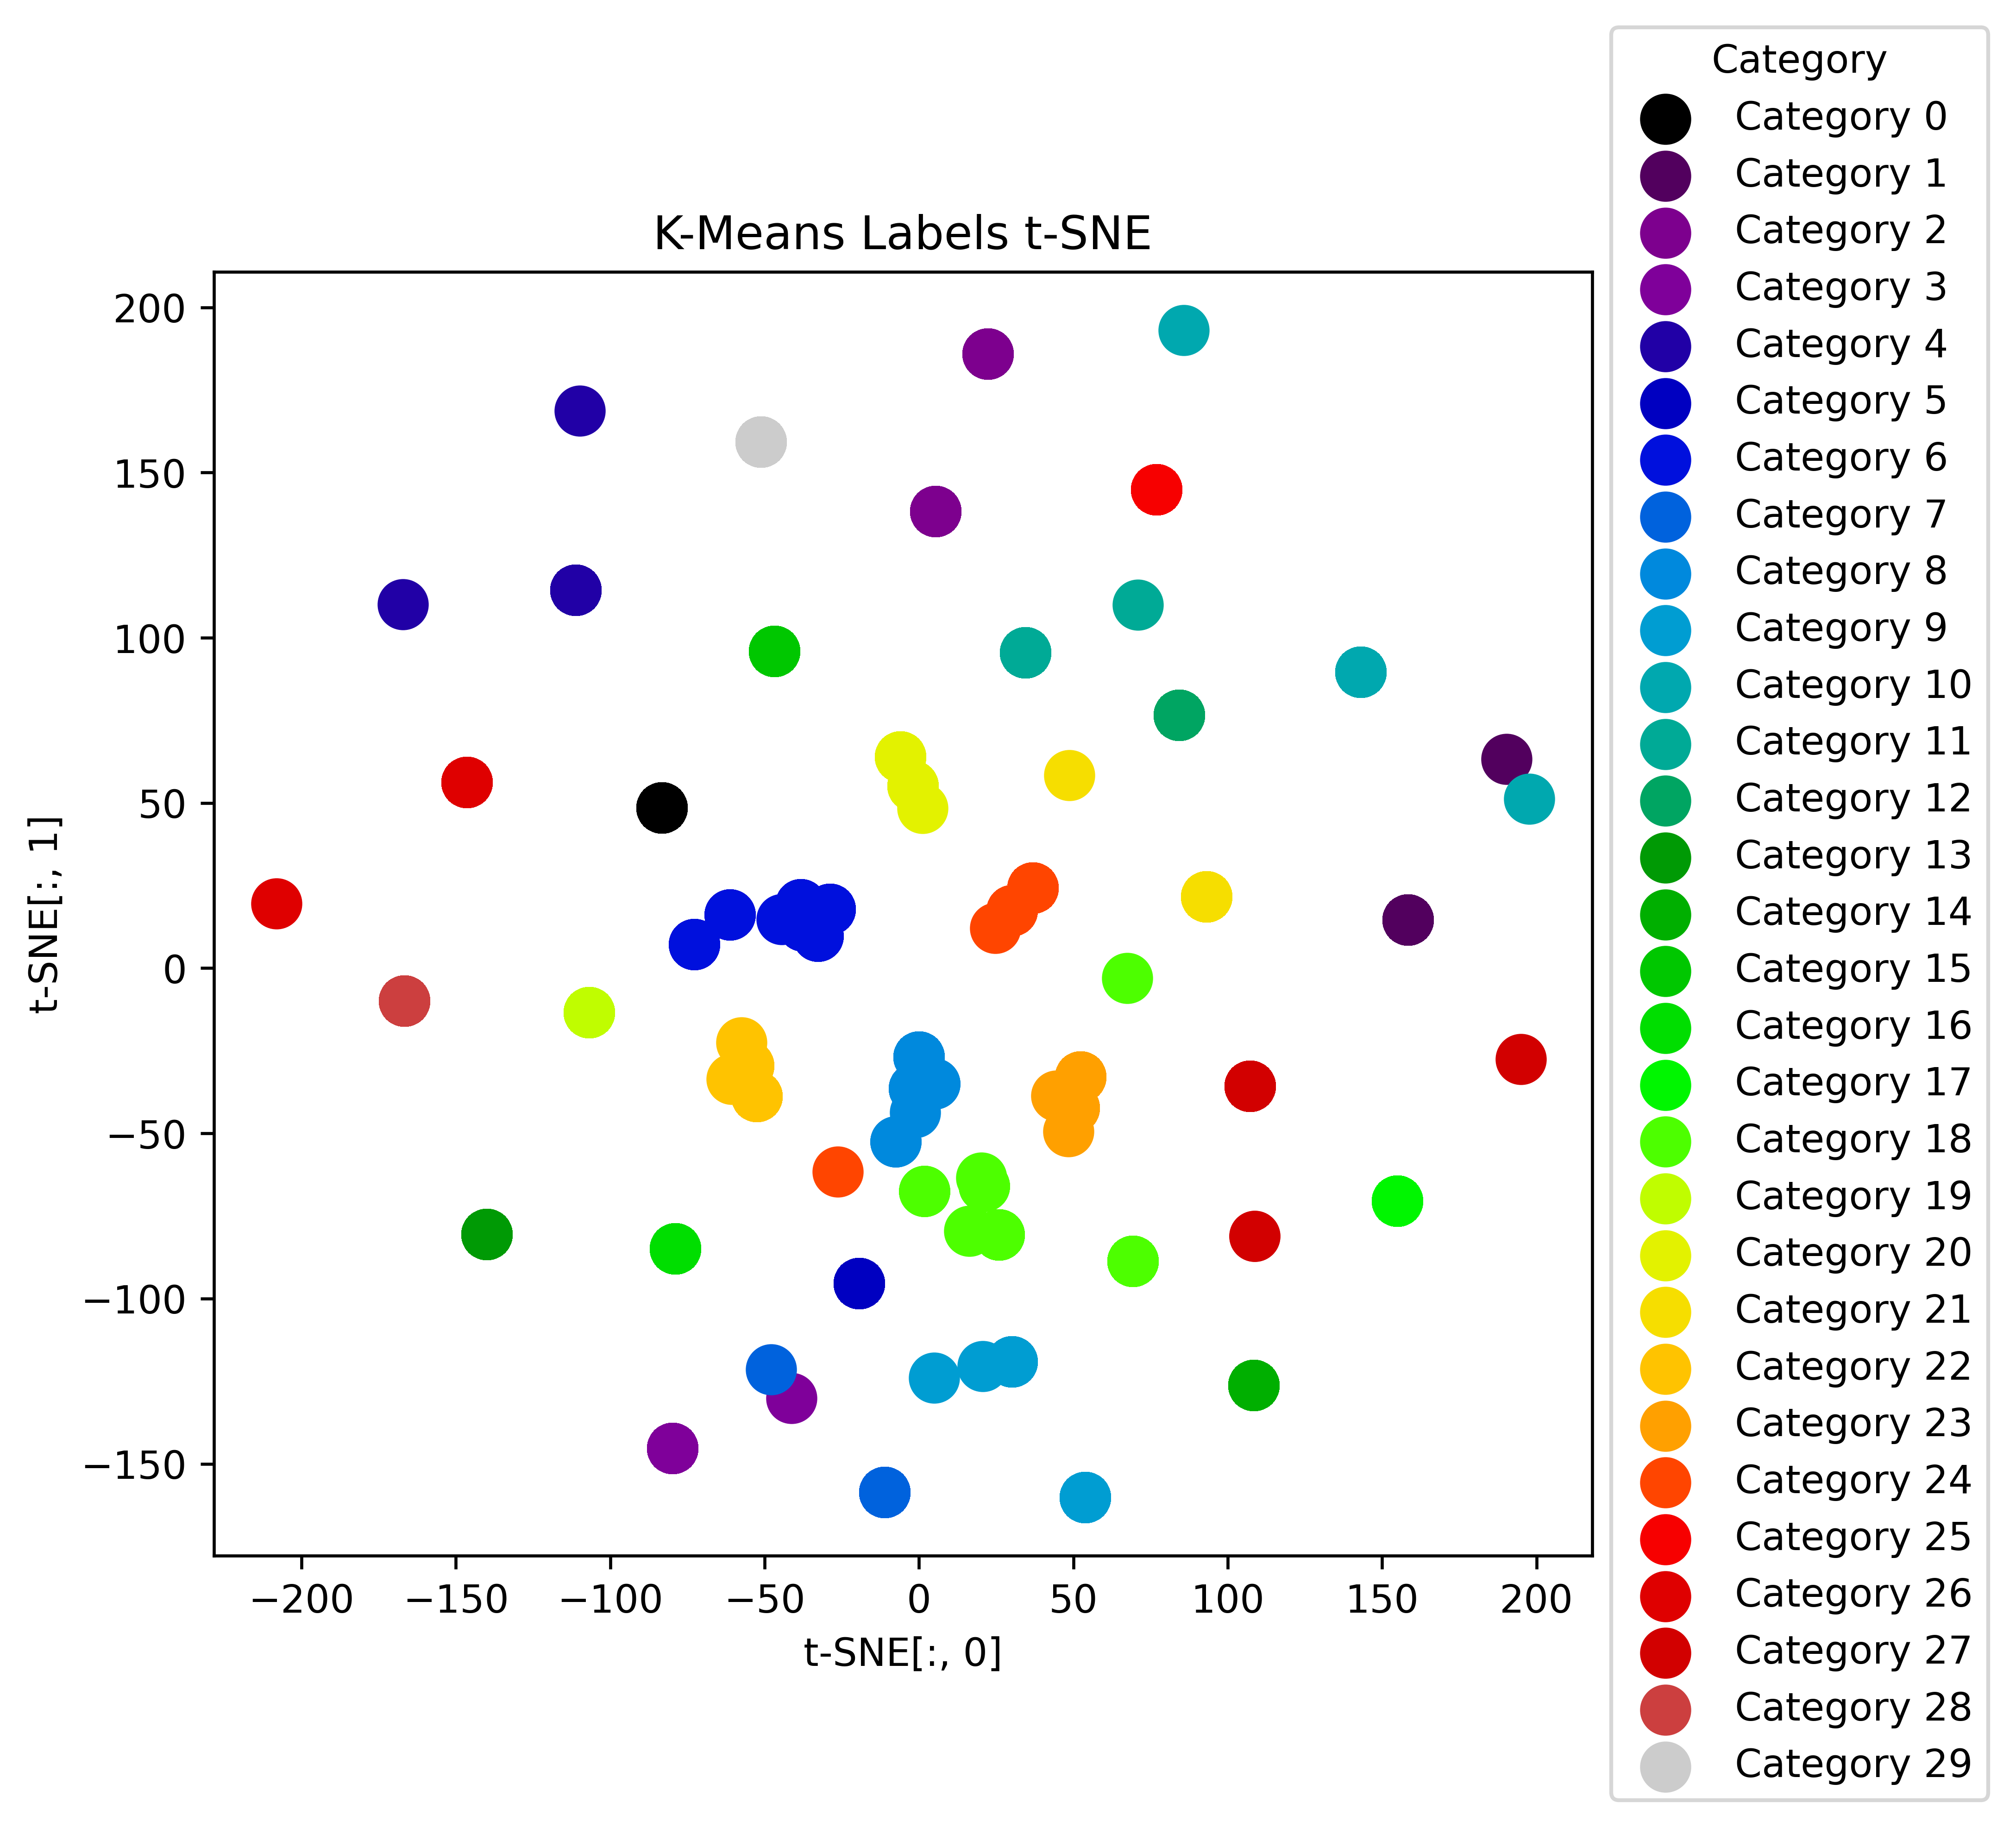

In [ ]:
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

unique_labels = np.unique(kmeans_labels)
for label in unique_labels:
    idx = kmeans_labels == label
    ax.scatter(captions_enc[idx, 0], captions_enc[idx, 1],
               color=cmap(label),
               label=f'Category {label}',
               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('K-Means Labels t-SNE')
plt.show()

<ipython-input-28-e8f2c41fea37>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


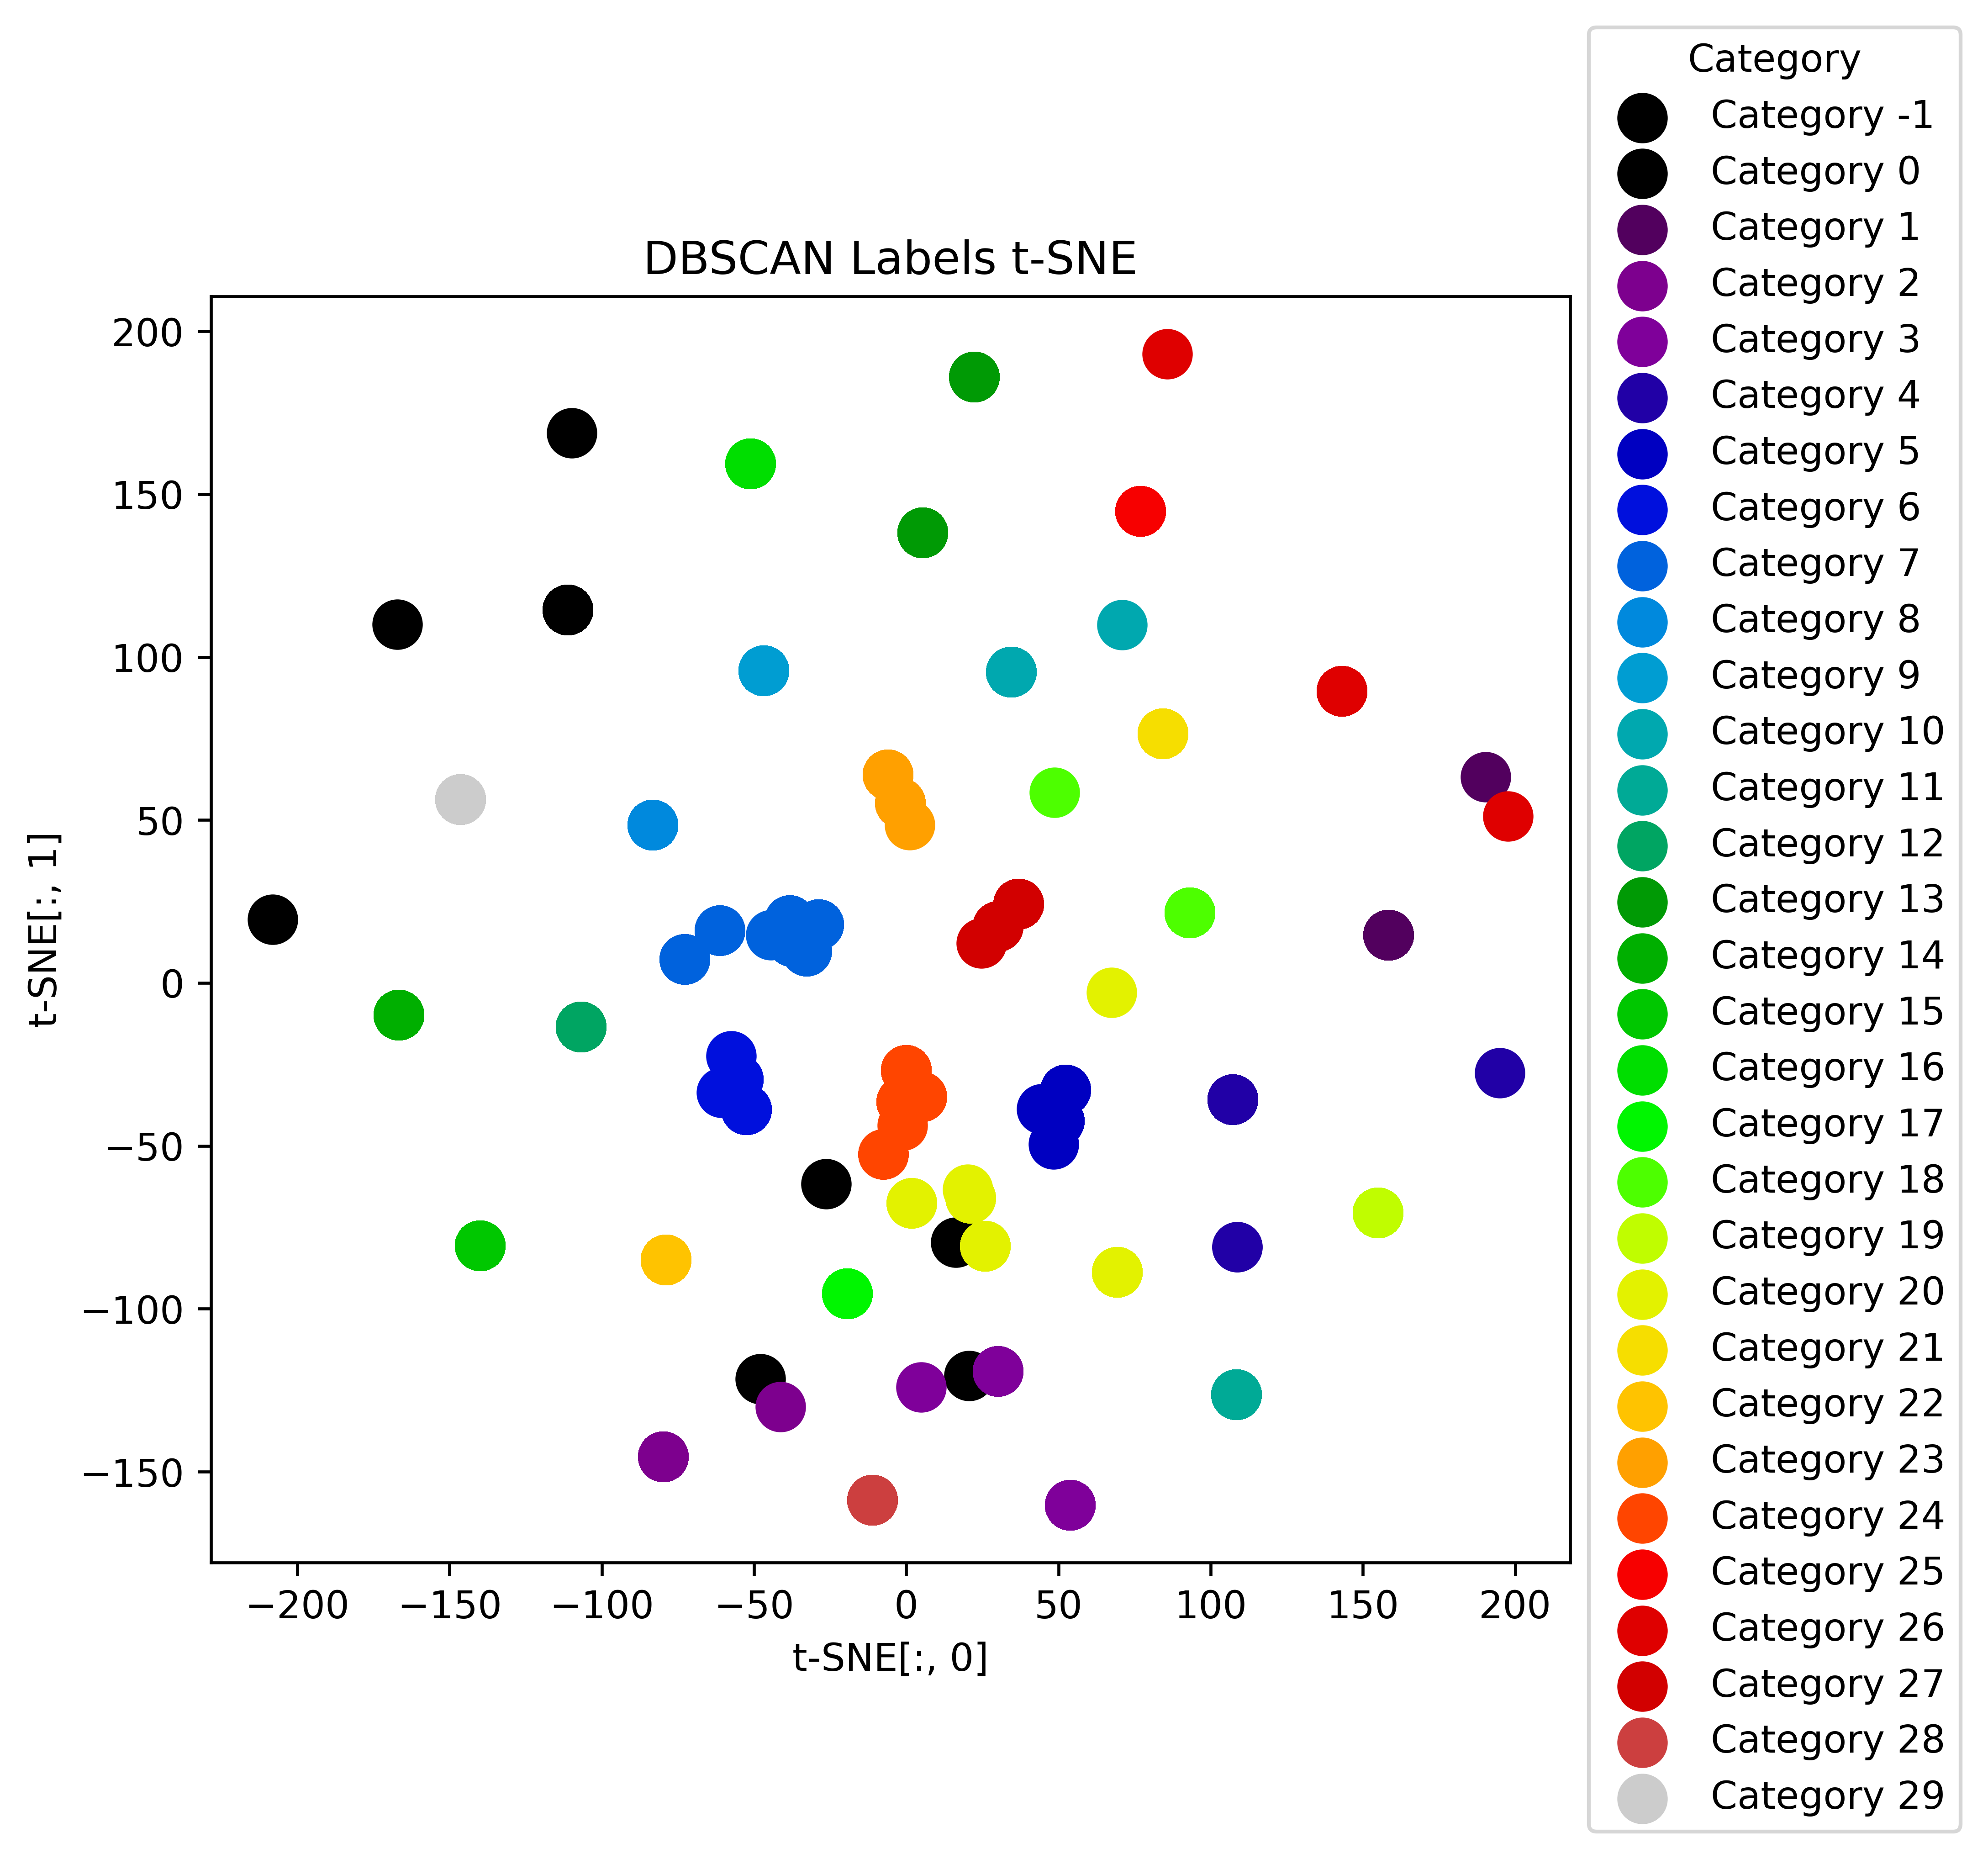

array([ 0,  1,  2, ..., 21, 26,  4])

In [ ]:
cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    idx = dbscan_labels == label
    ax.scatter(captions_enc[idx, 0], captions_enc[idx, 1],
               color=cmap(label),
               label=f'Category {label}',

               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('DBSCAN Labels t-SNE')
plt.show()

dbscan_labels

In [ ]:
len(unique_labels)

31

<ipython-input-30-1db3853ee474>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', 30)


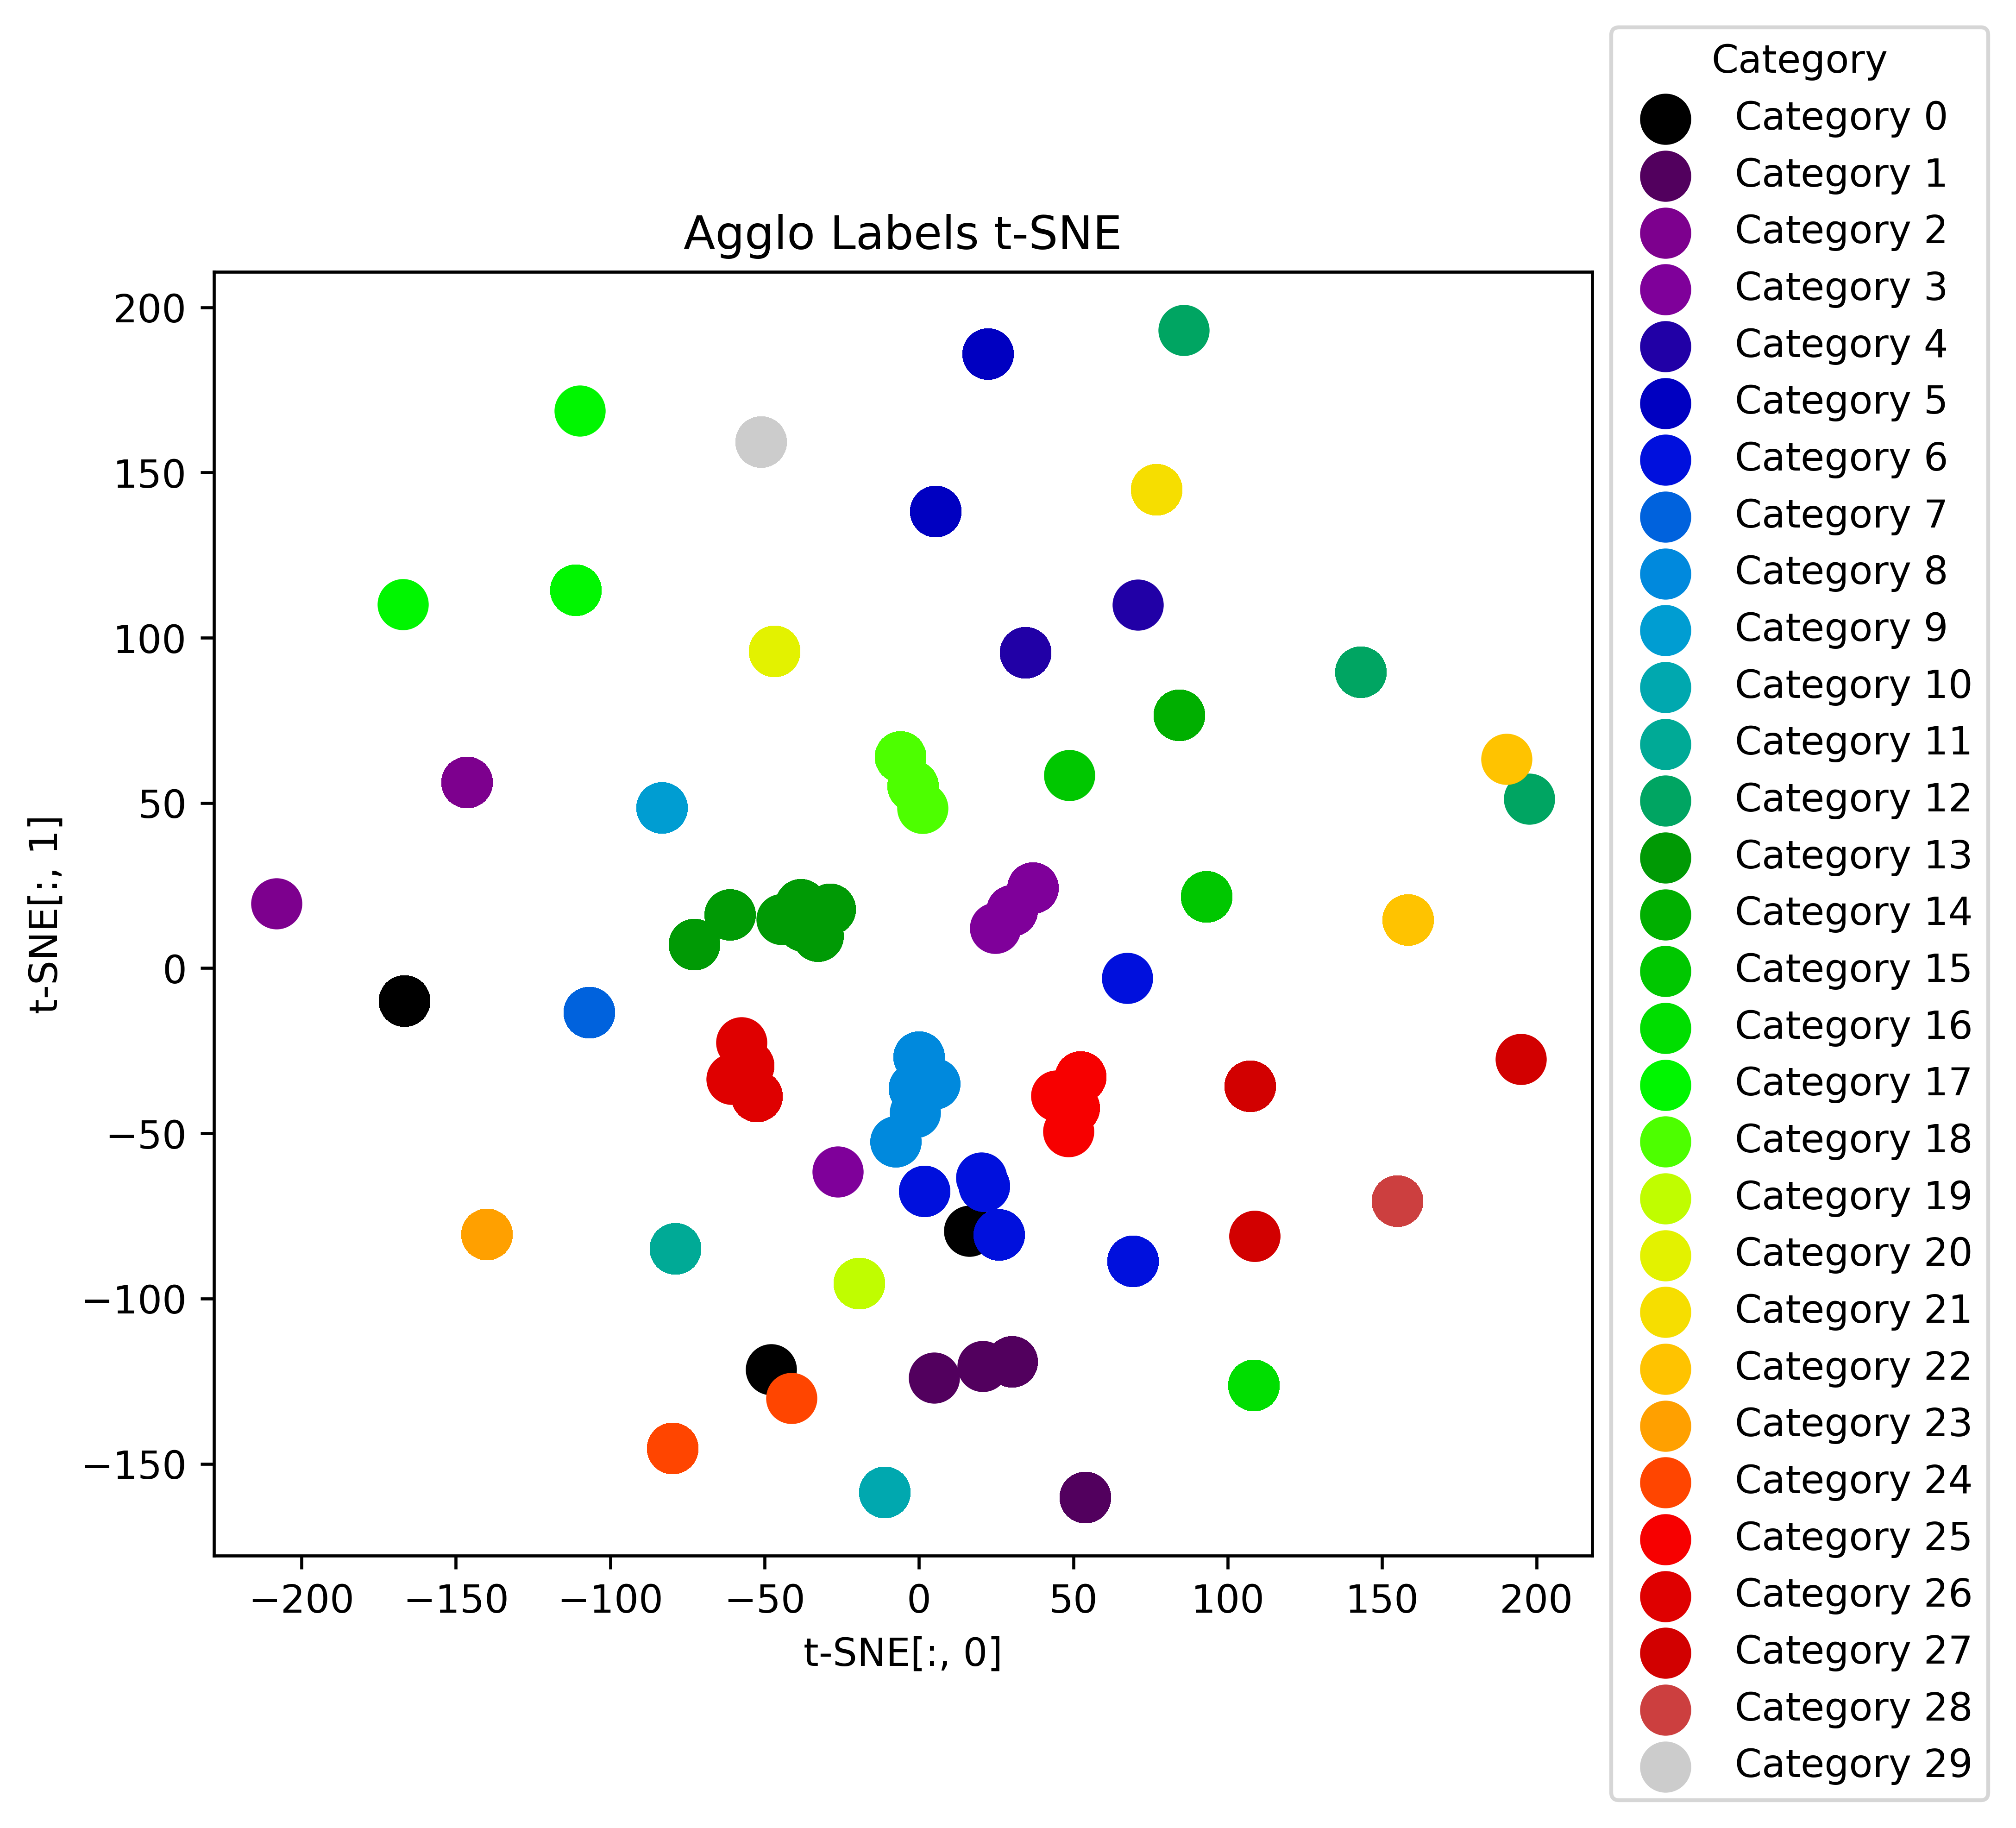

array([17, 22, 24, ..., 14, 12, 27])

In [ ]:
cmap = plt.cm.get_cmap('nipy_spectral', 30)

fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

unique_labels = np.unique(agglo_labels)
for label in unique_labels:
    idx = agglo_labels == label
    ax.scatter(captions_enc[idx, 0], captions_enc[idx, 1],
               color=cmap(label),
               label=f'Category {label}',

               s=150)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Category")

plt.xlabel('t-SNE[:, 0]')
plt.ylabel('t-SNE[:, 1]')
plt.title('Agglo Labels t-SNE')
plt.show()

agglo_labels